In [1]:
import os
import sys
import smbus

from math import log
from time import sleep
from datetime import datetime

In [2]:
# get current working directory and append relative path for package import
if os.name == 'posix':
    _wd = !pwd
    _wd = _wd[0]
elif os.name == 'nt':
    _wd = !cd
    _wd = _wd[0]
else:
    _wd = os.getcwd()
print('Current working directory is:', _wd)
p = os.path.dirname(_wd)
p = os.path.join(p, '.')
p = os.path.abspath(p)
print('Appending directory to path:', p)
sys.path.insert(0, p)

# alternatively, manually set the path to meerkat
#sys.path.insert(0, '/path_to_meerkat')

Current working directory is: /home/colin/code/meerkat/examples
Appending directory to path: /home/colin/code/meerkat


In [3]:
from meerkat import ads

In [4]:
i2c = smbus.SMBus(1)
dev = ads.ADS1115(bus=i2c)
dev.get_config()
dev.pga('6.144')

In [5]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 57600 0xe100 0b1110000100000000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 8 SPS
Input Multiplexer: 2G
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [6]:
def get_time():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

In [7]:
def R2(R1, Vin, Vout):
    """Voltage divider, unknown resistance with known resistance and voltages"""
    return R1 * (1 / ((Vin/Vout) - 1))

In [8]:
def steinhart_hart_equation(r, a, b, c):
    """Calculate temperature in Kelvin from a resistance
    based on the Steinhart–Hart equation

    Parameters
    ----------
    r : float, resistance of thermister
    a : float, coeffient
    b : float, coeffient
    c : float, coeffient

    Returns
    -------
    t : float, temperature in Kelvin
    """
    return 1.0 / (a + b * log(r) + c * (log(r) ** 3))
    
def kelvin_to_celcius(k):
    """Convert temperature in Kelvin to Celsius

    Parameters
    ----------

    k : float, temperature in degrees Kelvin
    Returns
    -------
    float, temperature in degrees Celsius
    """
    return k - 273.15

In [9]:
import time

In [10]:
dev.delay = 0.1

In [11]:
# Rough pass at temperature
# delay between reads and writes sometimes need to be increased
dev.delay = 0.1

# get voltages of pins
dev.mux('1G')     # pin 0 relative to ground
Vcc = dev.voltage()
time.sleep(1)
print('Measured Source voltage: {} V'.format(Vcc))
dev.mux('2G')     # pin 1 relative to ground
Vt = dev.voltage()
print('Measured Thermistor voltage: {} V'.format(Vt))

# calculate resistance of thermistor
Rt = R2(R1=10000, Vin=Vcc, Vout=Vt)
print('Measured resistance: {} ohms'.format(Rt))

# Thermistor is a Semitec 103AT-2 values from datasheet

a = 0.000811290160145459
b = 0.000211355789144265
c = 7.17614730463848e-08

a = 0.001129148
b = 0.000234125
c = 8.76741e-08

tK = steinhart_hart_equation(Rt, a, b, c)
tC = kelvin_to_celcius(tK)
print('Measured temperature: {} C'.format(tC))

Measured Source voltage: 2.048625 V
Measured Thermistor voltage: 0.9961875 V
Measured resistance: 9465.526456440408 ohms
Measured temperature: 26.25642388647691 C


In [12]:
a = 0.000811290160145459
b = 0.000211355789144265
c = 7.17614730463848e-08

tK = steinhart_hart_equation(Rt, a, b, c)
kelvin_to_celcius(tK)

83.81301446208676

In [13]:
samples = 20

In [20]:
data = []
for _ in range(samples):
    data.append([get_time()] + dev.get(sid='thermistor_test_' + str(_)))

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
df = pd.DataFrame(data)

In [23]:
df.head()

,0,1,2
0,2018-11-19 12:25:54.046020,thermistor_test_0,0.991688
1,2018-11-19 12:25:54.147677,thermistor_test_1,0.991500
2,2018-11-19 12:25:54.249267,thermistor_test_2,0.991500
3,2018-11-19 12:25:54.350722,thermistor_test_3,0.991500
4,2018-11-19 12:25:54.452076,thermistor_test_4,0.991500


In [24]:
df['Rt'] = df.iloc[:,2].apply(lambda Vt: R2(R1=10000, Vin=Vcc, Vout=Vt))

In [25]:
df['T'] = df.Rt.apply(lambda Rt: kelvin_to_celcius(steinhart_hart_equation(Rt, a, b, c)))

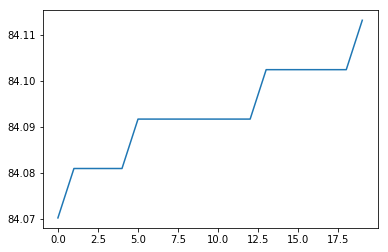

In [26]:
df['T'].plot();